# Изучение закономерностей, определяющих успешность компьютерных игр

**Ход исследования**:
1. Обзор данных.
2. Предообработка данных.
3. Исследовательский анализ данных.
4. Составление портрета пользователя каждого региона.
5. Проверка гипотез.
6. Общие выводы.

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# чтение файла с данными
df = pd.read_csv('/datasets/games.csv')
# получение общей информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Выводы**

В таблице есть пропуски в некоторых столбцах - при этом в столбцах `Critic_Score`, `User_Score`, `Rating` значительное количество пропусков.  
Названия столбцов приведены не в нижнем регистре.  
Типы данных в некоторых столбцах также следует преобразовать (например, год выпуска из *float* в *int*, `User_Score` из *object* в *float*). 

## Предообработка данных

### Переименование столбцов

Переименуем столбцы - приведем к нижнему регистру, кроме столбцов с продажами по регионам. 

In [4]:
df.columns= df.columns.str.lower()
df = df.rename(columns={
    'na_sales': 'NA_sales',
    'eu_sales': 'EU_sales',
    'jp_sales': 'JP_sales',
})
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Заполнение пропусков

Произведем подсчет количества пропусков.

In [5]:
# подсчет пропусков
df.isna().sum().to_frame()

,0
name,2
platform,0
year_of_release,269
genre,2
NA_sales,0
EU_sales,0
JP_sales,0
other_sales,0
critic_score,8578
user_score,6701


Посмотрим на пропуски в столбце `name`.  

Видно, что 2 пропуска совпадают с пропусками в столбце `genre`.

In [6]:
df[df['name'].isna() == True]

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим пропуски в указанных столбцах.

In [7]:
df = df.dropna(subset=['name', 'genre'])

Рассмотрим пропуски в годах выпуска игр.  
Учитывая, что в названии некоторых игр присутствует год, можно заполнить пропуски в `year_of_release` по числам в названии игры.  

In [8]:
df[df['year_of_release'].isna() == True].head(5)

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Создадим столбец `numbers_in_names`, в котором выделим числа из названий игр.

In [9]:
df['numbers_in_names'] = df['name'].str.extract('(\d+)').fillna('0').astype('int')
# отфильтруем значения в столбце, оставив числа с 1980 до 2016
print('Кол-во строк:', len(df.query\
('(year_of_release.isna() == True) & (numbers_in_names > 1980) & (numbers_in_names < 2016)')))

Кол-во строк: 17


Рассмотрим оставшиеся значения в созданном столбце `numbers_in_names`. 

Из таблицы ниже в качестве года также подходят значения "99" и "11" как 1999 и 2011 соответственно. 

In [10]:
# отфильтруем значения в столбце и рассмотрим оставшиеся значения
df[(df['year_of_release'].isna() == True) & \
   (df['numbers_in_names'] < 1980) & (df['numbers_in_names'] > 10)]\
['numbers_in_names'].value_counts().to_frame()

,numbers_in_names
99,2
20,2
64,1
500,1
11,1


Заполним пропуски в `year_of_release` для игр, в названии которых указан год, учитывая то, что обычно игра выпускается за 1 год, до указанного в названии игры года.

In [11]:
# заполнение пропусков в `year_of_release`
df.loc[(df['year_of_release'].isna() == True) & (df['numbers_in_names'] > 1980)\
       & (df['numbers_in_names'] < 2016), 'year_of_release'] = df['numbers_in_names'] - 1
df.loc[(df['year_of_release'].isna() == True) & (df['numbers_in_names'] == 99), 'year_of_release'] = 1998
df.loc[(df['year_of_release'].isna() == True) & (df['numbers_in_names'] == 11), 'year_of_release'] = 2010
# удаление вспомогательного столбца
df = df.drop(columns='numbers_in_names', axis=1)

Учитывая, что год выпуска игры является критической информацией для дальнейшего анализа оставшиеся пропуски в `year_of_release` удалим.

In [12]:
before = len(df)
df = df.dropna(subset=['year_of_release'])
after = len(df)
print('Количество удаленных строк:', before - after)
print("Доля удаленных строк: "'{0:.3%}'.format((before - after)/before))

Количество удаленных строк: 249
Доля удаленных строк: 1.490%


Заполним пропуски в столбце `rating` условным значением `Nan`.

In [13]:
df['rating'] = df['rating'].fillna('Nan')

Рассмотрим аббревиатуру `'tbd'` в столбце с оценкой пользователей, определим количество строк.

In [14]:
print('Кол-во строк:', len(df[df['user_score'] == 'tbd']))
df[df['user_score'] == 'tbd'].sample(5)

Кол-во строк: 2378


,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
16521,ESPN NBA 2Night 2002,XB,2002.0,Sports,0.01,0.00,0.0,0.00,NaN,tbd,E
8451,ZhuZhu Puppies,DS,2011.0,Simulation,0.12,0.03,0.0,0.01,NaN,tbd,E
11408,Martian Panic,Wii,2010.0,Adventure,0.08,0.00,0.0,0.00,NaN,tbd,T
7168,Discovery Kids: Dolphin Discovery,DS,2008.0,Simulation,0.20,0.00,0.0,0.01,NaN,tbd,E
15358,Taito Legends 2,PS2,2006.0,Misc,0.01,0.01,0.0,0.00,67.0,tbd,T


Строчное значение `'tbd'` заменим на NaN.

In [15]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец - `total_sales`.

In [16]:
df['total_sales'] = df['NA_sales'] + df['JP_sales'] + df['EU_sales'] + df['other_sales']

In [17]:
# итоговая проверка количества пропусков
df.isna().sum().to_frame()

,0
name,0
platform,0
year_of_release,0
genre,0
NA_sales,0
EU_sales,0
JP_sales,0
other_sales,0
critic_score,8467
user_score,8989


**Выводы**

Была произведена обработка пропусков:
* Совпадающие пропуски в `genre` и `name` в кол-ве 2 шт. были удалены;
* Пропуски в `year_of_release` частично были заполнены с использованием года в названии игры, оставшиеся пропуски были удалены, так как год выпуска игр является критической информацией для дальнейшего анализа;
* Пропуски в столбце `rating` были заполнены условным значением `Nan`;
* Аббревиатура ***'tbd'*** в столбце `user_score` была заменена на NaN, так как данное значение было в виде строки;
* Для оставшихся пропусков в столбцах `critic_score`, `user_score`, нет подходящего значения на замену.

Посчитаны суммарные продажи во всех регионах в столбец `total_score`.

### Изменение типов данных

Заменим тип данных в столбце `year_of_release` с вещественного на целочисленный.  
Заменим тип данных в столбцах `name`, `platform`, `genre` на string.  
С учетом пропусков заменим тип данных в столбце `critic_score` на целочисленный (Int64).  
Изменим тип данных в столбце `user_score` на float.

In [18]:
df['year_of_release'] = df['year_of_release'].astype('int')
df[['name', 'platform', 'genre']] = df[['name', 'platform', 'genre']].astype('string')
df['critic_score'] = df['critic_score'].astype('Int64')
df['user_score'] = df['user_score'].astype('float64')
# проверка изменения типа данных в столбцах
df[['year_of_release', 'name', 'platform', 'genre', 'critic_score', 'user_score']].dtypes.to_frame()

,0
year_of_release,int64
name,string
platform,string
genre,string
critic_score,Int64
user_score,float64


**Выводы**

В столбцах `name`, `platform`, `genre` тип данных изменен на ***string***.

В столбцах `year_of_release`, `critic_score` с учетом целочисленных значений в них тип данных изменен на ***int64***.  

В столбце `user_score` с учет данных в десятичных числах тип изменен на ***float***.

## Исследовательский анализ данных

### Количество выпускаемых игр по годам

Рассмотрим сколько игр выпускалось в разные годы - построим гистограмму и таблицу с группировкой по годам.  
Видно, что в до 2000 года игр выпускалось мало - до 400 штук в год.

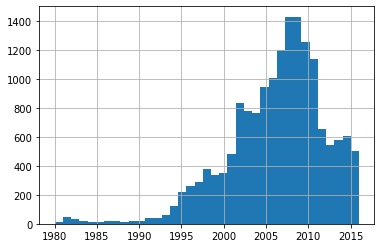

In [19]:
df['year_of_release'].hist(range=(1980,2016), bins=37);

In [20]:
df.groupby('year_of_release')['name'].count().to_frame().sort_values(by='year_of_release', ascending=False).\
head(16).reset_index()

,year_of_release,name
0,2016,502
1,2015,606
2,2014,581
3,2013,544
4,2012,654
5,2011,1136
6,2010,1257
7,2009,1426
8,2008,1428
9,2007,1199


**Выводы**

Можно считать, что данные до 2000 года не важны - ввиду малого количества выпущенных игр в указанный период.

### Продажи по платформам

Выберем топ 10 платформ с наибольшими суммарными продажами и сохраним в таблицу `top_platforms`. 

In [21]:
top_platforms = (df.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).
                 reset_index().head(10))
top_platforms

,platform,total_sales
0,PS2,1247.28
1,X360,961.30
2,PS3,931.34
3,Wii,891.90
4,DS,802.79
5,PS,729.04
6,PS4,314.14
7,GBA,312.88
8,PSP,290.34
9,3DS,257.81


Построим столбчатую диаграмму с распределением суммарных продаж по годам топ 10 платформ с 2001 года. 

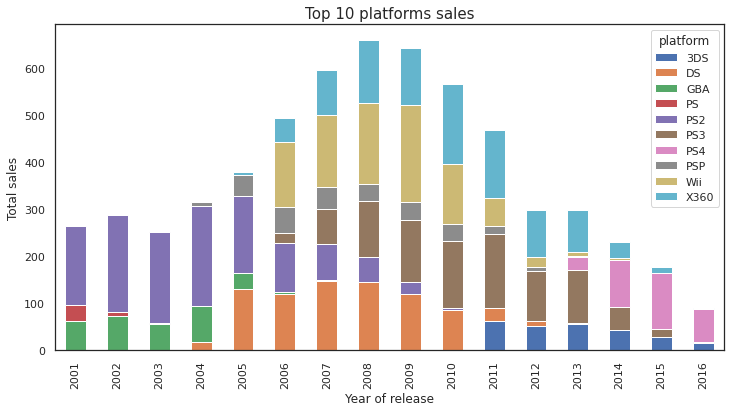

In [22]:
# из основного датафрейма отберем данные по топ 10 платформам, периоду с 2001 года и сформируем сводную таблицу
actual_years = list(range(2001, 2017))
top_platforms_sales = (df.query('(platform in @top_platforms.platform) & (year_of_release in @actual_years)').
                       pivot_table(index=['year_of_release'], columns='platform', values='total_sales', aggfunc='sum'))
# построим столбчатую диаграмму
sns.set(style='white')
top_platforms_sales.plot(kind='bar', stacked=True, figsize= (12, 6))
plt.title('Top 10 platforms sales', fontsize=15)
plt.ylabel('Total sales')
plt.xlabel('Year of release');

**Выводы**

Платформами с наибольшими продажами за весь период наблюдения являются PS2, X360 и PS3.  
По построенной диаграмме видно, что в среднем за **8-10 лет** появляются новые и исчезают старые платформы.

### Определение актуального периода

В целях определения актуального период построим диаграмму общих продаж по всем платформам с 2006 года, учитывая что каждые 8-10 лет платформы сменяются.

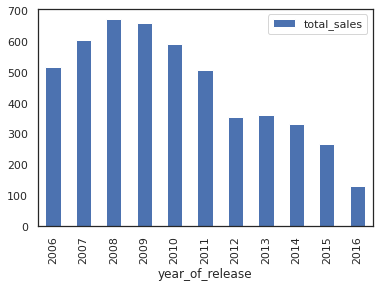

In [23]:
df.query('year_of_release >= 2006').pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum').\
plot(kind='bar');

**Выводы**

По диаграмме выше видно, что начиная с 2014 года начался спад продаж, связанный в том числе со сменой поколений популярных платформ - PS3 и X360 (хорошо заметно в диаграмме "*Top 10 platforms sales*" в разделе 3.2).    
С учетом этого, определим **актуальный период - начиная с 2014 года.**

In [24]:
# выделим актуальный датасет
dfa = df.query('year_of_release >= 2014')
print('Кол-во строк:', len(dfa))

Кол-во строк: 1689


### Выбор потенциально прибыльных платформ

Построим столбчатую диаграмму с распределением суммарных продаж по всем платформам за актуальный период.

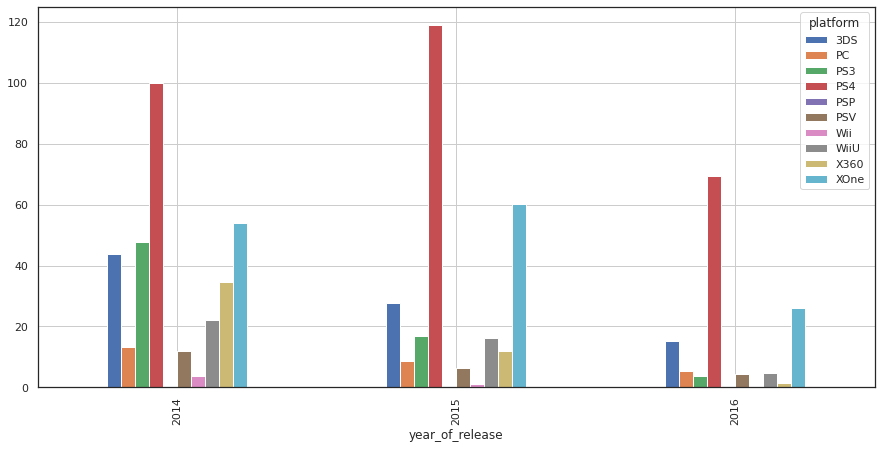

In [25]:
# построим столбчатую диаграмму
dfa.pivot_table(index=['year_of_release'], columns='platform', values='total_sales', aggfunc='sum').\
plot(kind='bar', figsize=(15, 7), grid=True);

**Выводы**

Из диаграммы видно следующее: 
- по продажам лидируют PS4 и XOne;
- также по PS4 и XOne растут продажи и доля продаж (учитывая, что данные за 2016 - неполные);
- падают продажи по PS3, X360, а также по 3DS.

Потенциально прибыльные платформы - PS4 и XOne.

### Диаграммы размаха по глобальным продажам игр в разбивке по платформам

Построим диаграммы размаха по глобальным продажам игр в разбивке по платформам.  
Для информативности разобъем диаграммы на 2 группы - с большими и низкими продажами.

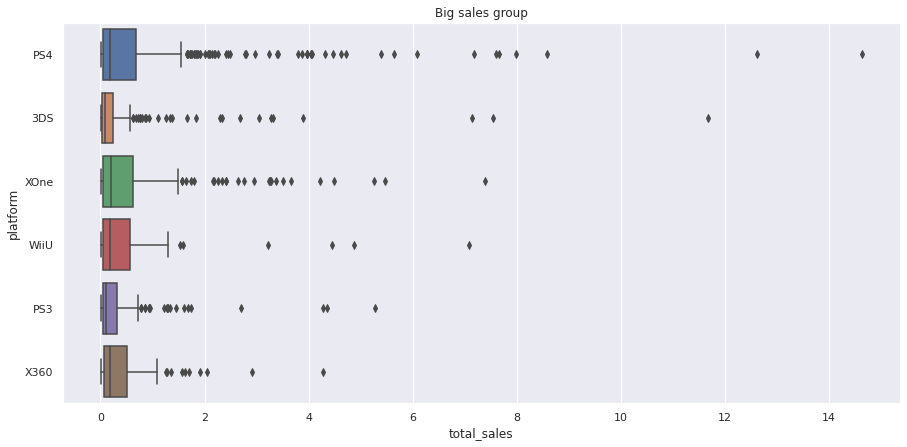

In [26]:
low_platforms_list = ['PC', 'Wii', 'PSV', 'PSP']
top_platforms = dfa.query('platform not in @low_platforms_list')
low_platforms = dfa.query('platform in @low_platforms_list')
# диаграмма размаха для платформ с относительно большими продажами
sns.set(rc={'figure.figsize':(15, 7)})
ax = (sns.boxplot(x='total_sales', y='platform', data=top_platforms, orient='h', fliersize=5).
     set_title('Big sales group'))

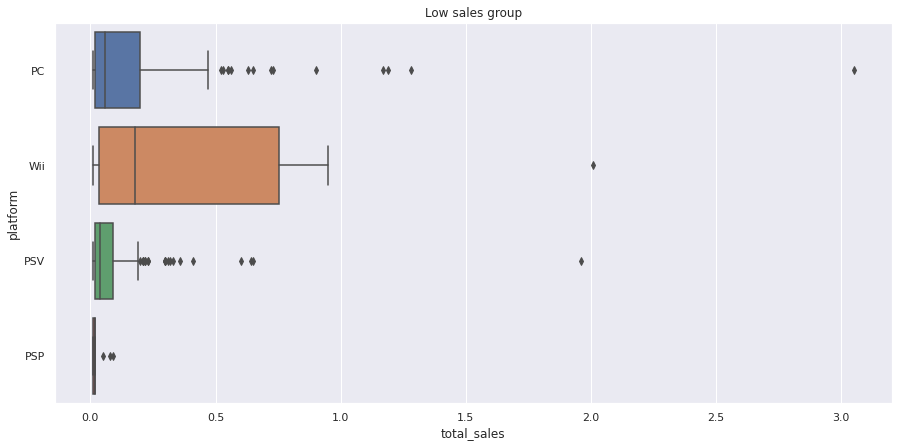

In [27]:
# диаграмма размаха для платформ с низкими продажами
sns.set(rc={'figure.figsize':(15, 7)})
ax = (sns.boxplot(x='total_sales', y='platform', data=low_platforms, orient='h', fliersize=5).
     set_title('Low sales group'))

In [28]:
(print("Доля продаж топ игры для PS4: "'{0:.0%}'.format
       (dfa.query('platform == "PS4"')['total_sales'].max()/dfa.query('platform == "PS4"')['total_sales'].sum())))

Доля продаж топ игры для PS4: 5%


**Выводы**

Почти во всех платформах есть очень популярные игры, обеспечивающие существенную долю суммарных продаж.

### Диаграммы рассеяния и корреляция между отзывами и продажами

В качестве популярной платформы выберем PS4.  
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Корреляция между отзывами критиков и продажами: 0.402661410681041


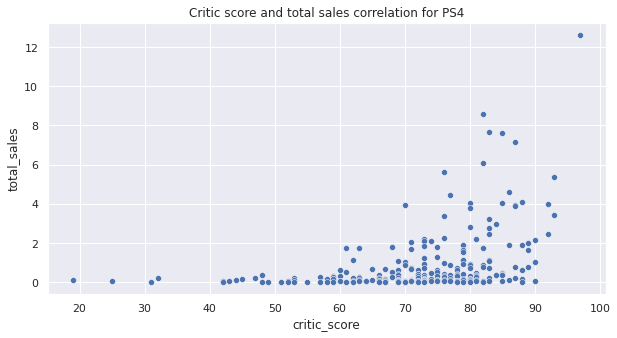

In [29]:
ps4_data = dfa.query('platform == "PS4"')
print('Корреляция между отзывами критиков и продажами:', \
      (ps4_data['critic_score'].astype('float64')).corr(ps4_data['total_sales']))
# построение диаграммы рассеяния между отзывами критиков и продажами
sns.set(rc={'figure.figsize':(10, 5)})
sns.scatterplot(data=ps4_data, x='critic_score', y='total_sales').set_title('Critic score and total sales correlation for PS4');

Корреляция между отзывами пользователей и продажами: -0.040131589472697356


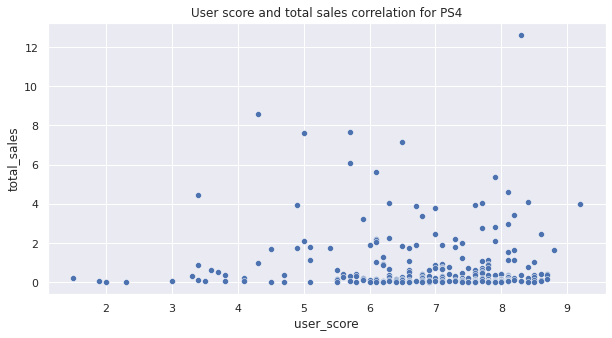

In [30]:
print('Корреляция между отзывами пользователей и продажами:', \
      (ps4_data['user_score'].astype('float64')).corr(ps4_data['total_sales']))
# построение диаграммы рассеяния между отзывами пользователей и продажами
sns.scatterplot(data=ps4_data, x='user_score', y='total_sales').set_title('User score and total sales correlation for PS4');

Рассмотрим аналогичные корреляции для остальных платформ.

In [31]:
dfa_without_ps4 = dfa.query('platform != "PS4"').dropna()
for platform, data in dfa_without_ps4.groupby('platform'):
    print(f'Корреляция между отзывами критиков и продажами в {platform}: \
    {(data["critic_score"].astype("float64")).corr(data["total_sales"]):.3} (кол-во оценок: {len(data["critic_score"])})')
print()
for platform, data in dfa_without_ps4.groupby('platform'):
    print(f'Корреляция между отзывами пользователей и продажами в {platform}: \
    {(data["user_score"].astype("float64")).corr(data["total_sales"]):.3} (кол-во оценок: {len(data["user_score"])})')

Корреляция между отзывами критиков и продажами в 3DS:     0.285 (кол-во оценок: 47)
Корреляция между отзывами критиков и продажами в PC:     0.172 (кол-во оценок: 115)
Корреляция между отзывами критиков и продажами в PS3:     0.447 (кол-во оценок: 36)
Корреляция между отзывами критиков и продажами в PSV:     0.041 (кол-во оценок: 53)
Корреляция между отзывами критиков и продажами в WiiU:     0.376 (кол-во оценок: 42)
Корреляция между отзывами критиков и продажами в X360:     0.526 (кол-во оценок: 26)
Корреляция между отзывами критиков и продажами в XOne:     0.422 (кол-во оценок: 151)

Корреляция между отзывами пользователей и продажами в 3DS:     0.28 (кол-во оценок: 47)
Корреляция между отзывами пользователей и продажами в PC:     -0.09 (кол-во оценок: 115)
Корреляция между отзывами пользователей и продажами в PS3:     0.157 (кол-во оценок: 36)
Корреляция между отзывами пользователей и продажами в PSV:     0.0235 (кол-во оценок: 53)
Корреляция между отзывами пользователей и продажами

**Выводы**

Для выбранной платформы PS4 выявлено следующее: 
 - Между отзывами критиков и продажами наблюдается прямая корреляция c коэффициентом 0.4 - высокие оценки критиков положительно сказываются на продажах;  
 - Отзывы пользователей не влияют на продажи, корреляция отсутствует.  

Для остальных платформ в целом также есть корреляция между отзывами критиков и продажами (кроме непопулярных платформ).  
Отзывы пользователей для остальных платформ тоже не влияют на продажи, кроме 3DS, WiiU и X360.  

### Общее распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам за актуальный период.

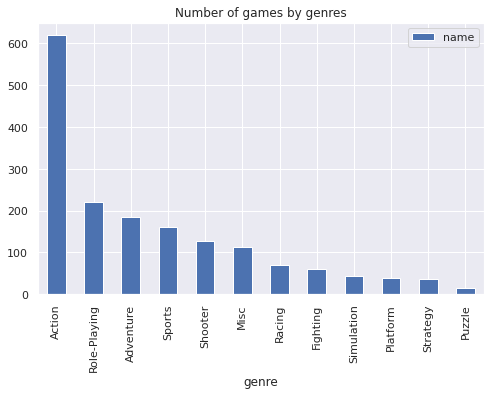

In [32]:
# распределение по кол-ву выпущенных игр
dfa.groupby('genre')['name'].count().to_frame().sort_values(by='name', ascending=False).reset_index().\
set_index('genre').plot(kind='bar', figsize=(8, 5), title='Number of games by genres');

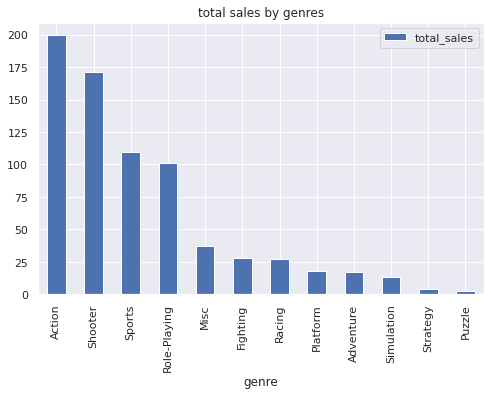

In [33]:
# распределение по продажам
dfa.groupby('genre')['total_sales'].sum().to_frame().sort_values(by='total_sales', ascending=False).reset_index().\
set_index('genre').plot(kind='bar', figsize=(8, 5), title='total sales by genres');

**Выводы**

Самыми прибыльными жанрами являются - Action, Shooter и Sports.  
Жанры с самыми низкими продажами - Puzzle, Strategy и Simulation.

## Составление портрета пользователя каждого региона

### Самые популярные платформы (топ-5)

Определим для пользователя каждого региона самые популярные платформы (топ-5).

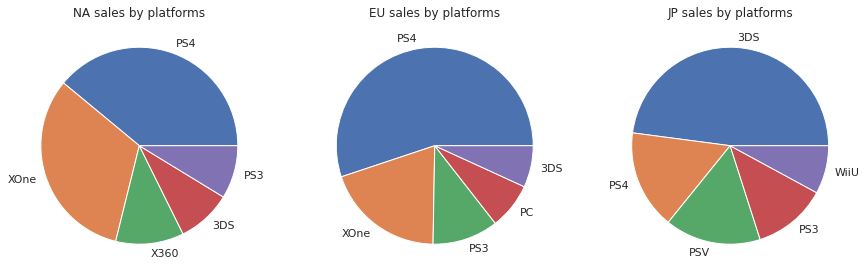

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# регион - NA
dfa.groupby('platform').agg({'NA_sales': 'sum'}).sort_values(by='NA_sales', ascending=False).reset_index().head(5).\
set_index('platform').plot(kind='pie', y='NA_sales', title='NA sales by platforms', ax=axes[0], legend=False, ylabel='')
# регион - EU
dfa.groupby('platform').agg({'EU_sales': 'sum'}).sort_values(by='EU_sales', ascending=False).reset_index().head(5).\
set_index('platform').plot(kind='pie', y='EU_sales', title='EU sales by platforms', ax=axes[1], legend=False)
# регион - JP
dfa.groupby('platform').agg({'JP_sales': 'sum'}).sort_values(by='JP_sales', ascending=False).reset_index().head(5).\
set_index('platform').plot(kind='pie', y='JP_sales', title='JP sales by platforms', ax=axes[2], legend=False);

**Выводы**

В Северной Америке самыми популярными платформами являются PS4 и XOne, причем их доля примерно совпадает.  
В Европе самой популярной платформой является PS4 с большим отрывом от XOne, в отличие от Сев. Америки заметная доля продаж по PC, X360 в Европе не попал в топ-5.     
В Японии самой популярной платформой является 3DS, также заметные доли продаж у WiiU и PSV.

### Самые популярные жанры (топ-5)

Определим для пользователя каждого региона самые популярные жанры (топ-5).

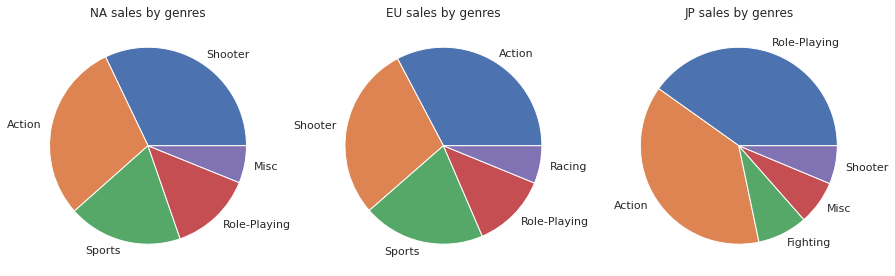

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# регион - NA
dfa.groupby('genre').agg({'NA_sales': 'sum'}).sort_values(by='NA_sales', ascending=False).reset_index().head(5).\
set_index('genre').plot(kind='pie', y='NA_sales', title='NA sales by genres', ax=axes[0], legend=False, ylabel='')
# регион - EU
dfa.groupby('genre').agg({'EU_sales': 'sum'}).sort_values(by='EU_sales', ascending=False).reset_index().head(5).\
set_index('genre').plot(kind='pie', y='EU_sales', title='EU sales by genres', ax=axes[1], legend=False)
# регион - JP
dfa.groupby('genre').agg({'JP_sales': 'sum'}).sort_values(by='JP_sales', ascending=False).reset_index().head(5).\
set_index('genre').plot(kind='pie', y='JP_sales', title='JP sales by genres', ax=axes[2], legend=False);



**Выводы**

В Сев. Америке и Европе самыми популярными жанрами являются Action, Shooter и Sports. В Европе также популярен Racing, а в Сев. Америке Misc.  
В Японии самым популярным жанром является Role-PLaying, также в топ-5 попал жанр Fighting.

### Влияние рейтинга ESRB на продажи в регионах

Определим влияние рейтинга ESRB на продажи в отдельном регионе.

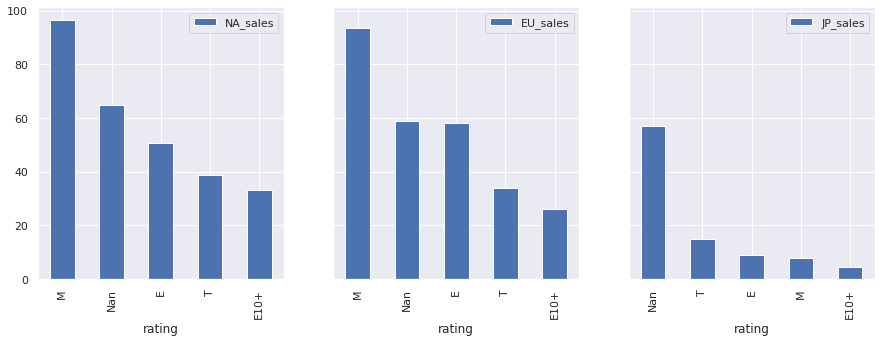

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
regions = ['NA_sales', 'EU_sales', 'JP_sales']
i = 0
for region in regions:
    dfa.groupby('rating').agg({region: 'sum'}).sort_values(by=region, ascending=False).reset_index().\
    set_index('rating').plot(kind='bar', ax=axes[i])
    i += 1


**Выводы**

По Сев. Америке и Европе влияние рейтинга ESRB на продажи игр одинаково - наибольшие продажи с рейтингом M, наименьшие продажи с рейтингом E10+.  
В Японии иная картина - наибольшие продажи игр с рейтингом T, наименьшие также с рейтингом E10+. Также по Японии очень большая доля пропусков в столбце с рейтингом ESRB - вероятно в Японии применяется другая рейтинговая система. 

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC

*Нулевая гипотеза:* средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
*Альтернативная гипотеза:* средние пользовательские рейтинги платформ Xbox One и PC различаются.   
*Критический уровень статистической значимости* примем в 1%, ввиду того, что размер выборки для проверки гипотезы достаточен.  

Применим t-тест о равенстве среднего двух генеральных совокупностей по взятым из них выборкам:

Выборка XOne: 165
Выборка PC: 122


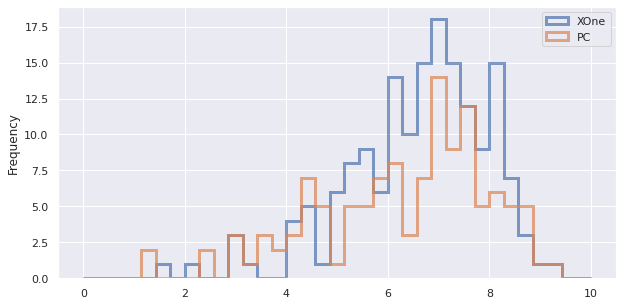

In [37]:
# определение размеров выборок
print('Выборка XOne:', len(dfa.query('(user_score.isna() == False) & (platform == "XOne")')))
print('Выборка PC:', len(dfa.query('(user_score.isna() == False) & (platform == "PC")')))
# построим гистограммы по пользовательским рейтингам XOne и PC 
data = dfa.query('user_score.isna() == False')
ax = data[data['platform'] == 'XOne'].plot(
    kind='hist', y='user_score', histtype='step', range=(0, 10), 
    bins=35, linewidth=3, alpha=0.7, label='XOne', legend=True)
data[data['platform'] == 'PC'].plot(
    kind='hist', y='user_score', histtype='step', range=(0, 10), bins=35,
    linewidth=3, alpha=0.7, label='PC', ax=ax, grid=True, legend=True);

In [38]:
# проведение t-теста
sample_1 = data[data['platform'] == 'XOne']['user_score']
sample_2 = data[data['platform'] == 'PC']['user_score']
alpha = .01
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


In [39]:
# Определение средних по выборкам
print('Среднее по выборке XOne:', sample_1.mean())
print('Среднее по выборке PC:', sample_2.mean())

Среднее по выборке XOne: 6.594545454545456
Среднее по выборке PC: 6.298360655737705


### Средние пользовательские рейтинги жанров Action и Sports

*Нулевая гипотеза:* средние пользовательские рейтинги жанров Action и Sports одинаковые.  
*Альтернативная гипотеза:* средние пользовательские рейтинги жанров Action и Sports различаются.   
*Критический уровень статистической значимости* примем в 1%, ввиду того, что размер выборки для проверки гипотезы достаточен.  

Применим t-тест о равенстве среднего двух генеральных совокупностей по взятым из них выборкам:

Выборка Action: 297
Выборка Sports: 127


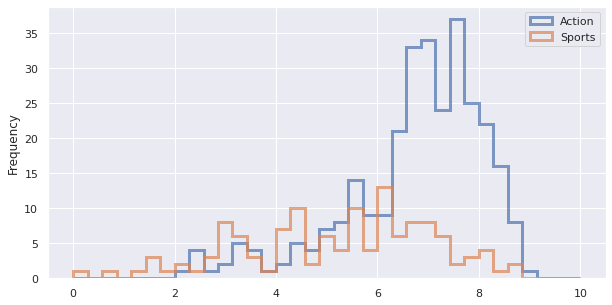

In [40]:
# определение размеров выборок
print('Выборка Action:', len(dfa.query('(user_score.isna() == False) & (genre == "Action")')))
print('Выборка Sports:', len(dfa.query('(user_score.isna() == False) & (genre == "Sports")')))
# построим гистограммы по пользовательским рейтингам XOne и PC 
ax = data[data['genre'] == 'Action'].plot(
    kind='hist', y='user_score', histtype='step', range=(0, 10), 
    bins=35, linewidth=3, alpha=0.7, label='Action', legend=True)
data[data['genre'] == 'Sports'].plot(
    kind='hist', y='user_score', histtype='step', range=(0, 10), bins=35,
    linewidth=3, alpha=0.7, label='Sports', ax=ax, grid=True, legend=True);

In [41]:
# проведение t-теста
sample_A = data[data['genre'] == 'Action']['user_score']
sample_S = data[data['genre'] == 'Sports']['user_score']
alpha = .01
results = st.ttest_ind(
    sample_A, 
    sample_S,
    equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


In [42]:
# Определение средних по выборкам
print('Среднее по выборке Action:', sample_A.mean())
print('Среднее по выборке Sports:', sample_S.mean())

Среднее по выборке Action: 6.760606060606061
Среднее по выборке Sports: 5.2251968503937


**Выводы**

По результатам проверки 2-х гипотез можно сделать следующие выводы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports разные.

## Общие выводы

Изучены данные - исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

Произведена предообработка данных:
* переименование столбцов - приведение названий столбцов к нижнему регистру;
* заполнение пропусков - пропуски в `year_of_release` частично были заполнены с использованием года в названии игры, оставшиеся пропуски были удалены, так как год выпуска игр является критической информацией для дальнейшего анализа, пропуски в столбце `rating` были заполнены условным значением `Nan`, для оставшихся пропусков в столбцах `critic_score`, `user_score` нет подходящего значения на замену;
* изменение типов данных - данные с целыми числами переведены в int, вещественные - в float, строчные - в string;

Произведен исследовательский анализ данных с построением диаграмм и графиков:
* до 2000 года выпускалось менее 400 игр в год;
* выявлено что каждые 8-10 лет платформы сменяются;
* актуальным является период с 2014 по 2016 годы;
* потенциально прибыльные платформы - PS4 и XOne;
* во всех платформах есть очень популярные игры, обеспечивающие значительные доли продаж;
* в целом отзывы критиков влияют на продажи, в то время как между отзывами пользователей и продажами корреляция отсутствует;
* самые популярные жанры - Action, Shooter, Sport, самые непопулярные - Puzzle, Strategy и Simulation.

Составлен портрет пользователя каждого региона:
* пользователи Европы и Сев. Америки в целом отличаются не сильно: популярные платформы - PS4 и XOne, популярные жанры - Action и Shooter, самые продаваемые игры - с рейтингом M;
* пользователи Японии существенно отличаются от пользователей Европы и Сев. Америки: самая популярная платформа - 3DS, также среди популярных - WiiU, популярный жанр - Role-Playing, самые продаваемые игры - с рейтингом T, также по Японии значительная доля пропусков рейтинга - вероятно применяется иная рейтинговая система.

Проверены 2 гипотезы, по которым можно сделать вывод о том, что:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports разные.

**Рекомендации для проведения рекламной кампании на 2017 год:**
* основные рекламируемые игры для Европы и Сев. Америки - жанра Action, Shooter и Sport для PS4 и XOne, с хорошими отзывами критиков, с рейтингом M;
* для Японии - жанра Role-Playing, Action и Fighting, на платформах 3DS и PS4, с хорошими отзывами критиков.